### This notebook preps the data for the Build_UserFeature_Matrix notebook. 
    1. Remove non red or white wine product keys from the product data
    2. Filter out customers with less than 3 red or white wine purchases
    3. Bucket wines into 1 - 5 categories based on number of purchases 
    4. Get top K rated wines from the top Q varietals
    
    
In Build_UserFeature_Matrix botebook, wine product keys with no purchases will not be included in the user_feature matrix. Therefore, these same wines won't be recommended. Only wines with at least a single purchase will make their way to the recommender and have the potential to be recommended. 
        Remove red and white wine product keys with no purchases 
         -- Columns of zeros contribute nothing toward recommendations

In [1]:
import numpy as np
import pandas as pd
import cPickle
import matplotlib.pyplot as plt
from collections import Counter
% matplotlib inline

In [2]:
# needs access to wifi
import plotly.graph_objs as go
import plotly.plotly as py

#### Load Data

In [13]:
wine_path = "/Users/Alexander/WINE/data/Products.txt"
purchases_path = "/Users/Alexander/WINE/data/Purchases.txt"

In [4]:
products_df = pd.read_csv(wine_path, sep = '\t')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
purchase_df = pd.read_csv(purchases_path, sep = '\t')

### Remove non red or white wine product keys from the product data

In [6]:
# isolate wines from other drinks (Product Types)
white_wine_mask = products_df.Class == 'White Wines'
red_wine_mask = products_df.Class == 'Red Wines'

In [7]:
white_wine_df = products_df[white_wine_mask]
red_wine_df = products_df[red_wine_mask]

In [8]:
# build wine df
wine_df = red_wine_df.append(white_wine_df)

In [9]:
wine_cols = [u'ProductKey', u'ProductId', u'Appellation', u'Varietal', u'Vineyard']

In [10]:
wine_df = wine_df[wine_cols]

In [11]:
# exclusively red and white wine product keys
wine_df.head()

,ProductKey,ProductId,Appellation,Varietal,Vineyard
0,2,127554,Napa Valley,Cabernet Sauvignon,Turnbull
1,3,133070,Napa Valley,Cabernet Sauvignon,Turnbull
2,4,114037,Napa Valley,Cabernet Sauvignon,Turnbull
5,7,109508,Napa Valley,Other Red Blends,Turnbull
6,8,110277,Napa Valley,Merlot,Turnbull


### Filter out customers with less than 3 red or white wine purchases

In [12]:
purchase_df.head()

,CustomerHash,PurchaseHash,ProductKey,Date,Units
0,F1923160355C00D4D1E7801F74132540,C60D8C98A7328EF5A1F5090D6A29DB7F,222650,2015-06-18,1
1,D3BE5BC2AA8796FCD402023CD6E5A6AC,C9F6085954D5D36615EE0BA44BEB0A2A,95350,2009-08-04,1
2,00D7447BAB0443738F81C3660F478357,18B773B0D5568E406CBB946F628C1DC6,38706,2007-12-10,1
3,F3548BD72E0F97ECBDA95918DE2743AD,96FEEC28AB4F35342DE08987D39406FC,333116,2012-03-16,2
4,9A260E4A83A112AA06F06A11DBF98BBD,07879D41A42AD75F020E3DA70D698ACC,221136,2007-05-08,1


In [13]:
red_white_product_keys = wine_df.ProductId.unique()

In [14]:
wine_purchase_df = purchase_df[purchase_df['ProductKey'].isin(red_white_product_keys)]

In [15]:
# these customers have purchased 3, or more, wines 
wine_purchase_df.head()

,CustomerHash,PurchaseHash,ProductKey,Date,Units
1,D3BE5BC2AA8796FCD402023CD6E5A6AC,C9F6085954D5D36615EE0BA44BEB0A2A,95350,2009-08-04,1
5,64F6A2CEC420680A259172BF4CF17CE2,4298C2D3673C22E2319F6A6D6C6AEE43,95375,2011-04-22,1
16,6131DC57D6050C3EB674DD8722C83B2B,35DB015FB5F5873924A6B569DA88CCCC,79964,2015-03-25,1
17,525CD8F0BF94E814F16F4FA947B995B6,4A99CE4E5571FCA366E43D9E928DC19F,102020,2013-10-18,12
18,710DBFAAB43DF7B5E304ED0D26B7966A,6AC657FD2D473FD0816E3D2E916AB012,129946,2013-11-26,1


### Save data to file

In [2]:
home = "/Users/Alexander/WINE/data/"
purchase_path = home + "customers_df_red_white_at_least_3.pkl"
wine_path = home + "wine_df_red_white_only.pkl"

In [17]:
#wine_purchase_df.to_pickle(purchase_path)

In [18]:
#wine_df.to_pickle(wine_path)

### Load from file

In [3]:
purchase_df = pd.read_pickle(purchase_path)

In [20]:
product_df = pd.read_pickle(wine_path)

### Bucket wines into 1 - 5 categories based on number of purchases 
    Map number of purchases to categories
    Ensure balanced classes

In [18]:
wine_purchase_df = pd.read_csv(purchases_path, sep="\t")

In [19]:
wine_purchase_df.head()

,CustomerHash,PurchaseHash,ProductKey,Date,Units
0,F1923160355C00D4D1E7801F74132540,C60D8C98A7328EF5A1F5090D6A29DB7F,222650,2015-06-18,1
1,D3BE5BC2AA8796FCD402023CD6E5A6AC,C9F6085954D5D36615EE0BA44BEB0A2A,95350,2009-08-04,1
2,00D7447BAB0443738F81C3660F478357,18B773B0D5568E406CBB946F628C1DC6,38706,2007-12-10,1
3,F3548BD72E0F97ECBDA95918DE2743AD,96FEEC28AB4F35342DE08987D39406FC,333116,2012-03-16,2
4,9A260E4A83A112AA06F06A11DBF98BBD,07879D41A42AD75F020E3DA70D698ACC,221136,2007-05-08,1


In [20]:
productKey_units = wine_purchase_df.groupby(["ProductKey"])["Units"].sum()

In [21]:
n_purchases = productKey_units.sort_values()

In [22]:
productKeys = n_purchases.index

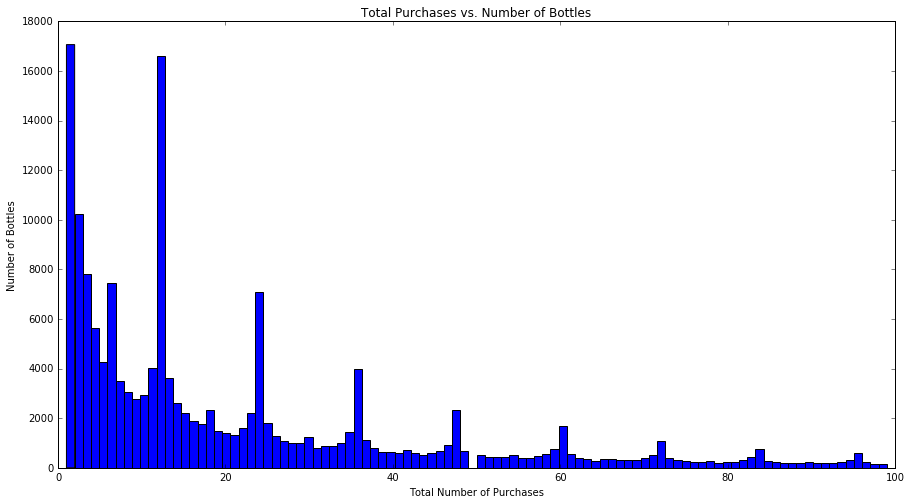

In [33]:
# unpopular wines are to the left of the hist
# popular wines are to the right of the hist
# the frist bar tells us that there are a lot of wines that were only purchased once
plt.figure(figsize = (15,8));
plt.title("Total Purchases vs. Number of Bottles");
plt.hist(n_purchases[n_purchases < 100], bins=100);
plt.xlabel("Total Number of Purchases")
plt.ylabel("Number of Bottles");
#plt.savefig("/Users/Alexander/WINE/data/Total_Purchases_vs_Number_of_Bottles.png")

In [96]:
data = [
    go.Histogram(
        x=n_purchases[n_purchases < 100]
    )
]
plot_url = py.iplot(data, filename='basic-histogram')

In [97]:
plot_url

Due to the distribution of the data, number of purchases can be categorized bewteen 1 - 5 or 1 - 10. 
Here, we want to stick to the rating convention of 1 - 5. 


Purchase Ranges:

    1) 1 - 11
    2) 12 - 23
    3) 24 - 47
    4) 48 - 147
    5) 138 - above


Alternate Ranges:

    1) 1 - 5
    2) 6 - 11
    3) 12 - 17
    4) 18 - 23
    5) 24 - 35
    6) 36 - 47
    7) 48 - 59
    8) 60 - 71
    9) 72 - 95
    10) 96 - above




In [8]:
def map_n_purchases_to_5_category(df):
    ratings = [] 
    wine_ids = []
    units = []
    for wine_id, n_units in zip(df.index, df.values):
        #cust_tag = tag_wineID[0]
        if n_units <= 11:
            wine_ids.append(wine_id)
            ratings.append(1)
            units.append(n_units)
        elif n_units >=12 and n_units <=23:
            wine_ids.append(wine_id)
            ratings.append(2)
            units.append(n_units)
        elif n_units >=24 and n_units <=47:
            wine_ids.append(wine_id)
            ratings.append(3)
            units.append(n_units)
        elif n_units >=48 and n_units <=147:
            wine_ids.append(wine_id)
            ratings.append(4)
            units.append(n_units)
        elif n_units >=148:
            wine_ids.append(wine_id)
            ratings.append(5)
            units.append(n_units)
        else:
            print "ERROR: num of units {0} for tag {1} do not fall in ranges ".format(n_units, cust_tag)
    return ratings, wine_ids, units

In [9]:
ratings, wine_ids, units_purchased = map_n_purchases_to_5_category(productKey_units)

In [10]:
print len(wine_ids)
print len(units_purchased)

48330
48330


In [110]:
five_total = float(np.sum(Counter(ratings).values()))

The class are relatively balanced and represent the distribution of purchases well

In [111]:
for key, value in Counter(ratings).iteritems():
    print "label {},  percent {:.3}".format(key, (value/five_total) * 100)

label 1,  percent 36.0
label 2,  percent 21.3
label 3,  percent 16.7
label 4,  percent 16.5
label 5,  percent 9.42


### Create Ratings DataFrame

In [11]:
pseudo_ratings_df = pd.DataFrame(data=ratings, columns=["Ratings"])

In [12]:
pseudo_ratings_df["ProductKey"] = wine_ids

In [13]:
pseudo_ratings_df.head()

,Ratings,ProductKey
0,2,4
1,1,6
2,1,9
3,4,10
4,5,14


In [14]:
cols = ["CustomerHash", "ProductKey"]

In [15]:
wine_purchase_df = wine_purchase_df[cols]

In [16]:
wine_purchase_df.head()

,CustomerHash,ProductKey
1,D3BE5BC2AA8796FCD402023CD6E5A6AC,95350
5,64F6A2CEC420680A259172BF4CF17CE2,95375
16,6131DC57D6050C3EB674DD8722C83B2B,79964
17,525CD8F0BF94E814F16F4FA947B995B6,102020
18,710DBFAAB43DF7B5E304ED0D26B7966A,129946


In [17]:
ratings_df = wine_purchase_df.merge(pseudo_ratings_df, how="left", on="ProductKey")

In [36]:
ratings_df.sort_values(by="ProductKey").head()

,CustomerHash,ProductKey,Ratings
1107557,4F10404CC10255ECEFA056E2A993EC18,4,2
1359581,7C9890212043EB1D7BA30D2F2ACD7822,4,2
1076307,E4954F3F432A5BC5F82EFF4602BA9F13,4,2
288632,CD4E82A94C6CA1A217FD7E053F83D910,4,2
145768,E3AAD20AC54CD33B7AD4319E8B4B5648,4,2


In [37]:
home = "/Users/Alexander/WINE/data/"
pseudo_ratings_path = home + "ratings_df.pkl"

In [38]:
ratings_df.to_pickle(pseudo_ratings_path)

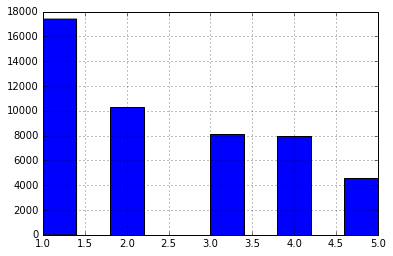

In [33]:
# Distribution of unique wine's ratings 
# most wines have a low rating because they were purchased only a few times
pseudo_ratings_df.Ratings.hist();

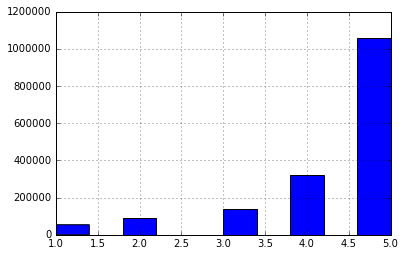

In [32]:
# Distribution of purchased wine's ratings
# most of the purchased wines have a high rating because individual bottles were purchased several times over
ratings_df.Ratings.hist();

###  Get top K rated wines from the top Q varietals

In [7]:
purchase_df.head()

,CustomerHash,ProductKey,Ratings
0,D3BE5BC2AA8796FCD402023CD6E5A6AC,95350,5
1,64F6A2CEC420680A259172BF4CF17CE2,95375,4
2,6131DC57D6050C3EB674DD8722C83B2B,79964,5
3,525CD8F0BF94E814F16F4FA947B995B6,102020,5
4,710DBFAAB43DF7B5E304ED0D26B7966A,129946,3


In [8]:
product_df.head()

,ProductKey,ProductId,Appellation,Varietal,Vineyard
0,2,127554,Napa Valley,Cabernet Sauvignon,Turnbull
1,3,133070,Napa Valley,Cabernet Sauvignon,Turnbull
2,4,114037,Napa Valley,Cabernet Sauvignon,Turnbull
5,7,109508,Napa Valley,Other Red Blends,Turnbull
6,8,110277,Napa Valley,Merlot,Turnbull


In [10]:
full_data_df = purchase_df.merge(product_df, how="left", on="ProductKey")

In [23]:
# get count of ratings for each varietal 
var_count = full_data_df.groupby(["Varietal"])["Ratings"].count()

In [12]:
# add ratings for each varietal
var_rat = full_data_df.groupby(["Varietal"])["Ratings"].sum()

In [25]:
var_count.sort_values(ascending=False, inplace=True)

In [19]:
# sort so varietals with the highest rating sums are displayed at the top
var_rat.sort_values(ascending=False, inplace=True)

In [30]:
# divide varietal ratings by varietal count in order to normalize values
normalized_varietal_ratings = var_rat/var_count

In [31]:
normalized_varietal_ratings.sort_values(ascending=False, inplace=True)

### Top 10 Rated Varietals 

In [136]:
top_10_varietals = normalized_varietal_ratings[0:10]

In [137]:
top_10_varietals

Varietal
Mourvedre             4.704632
Grenache              4.607134
Tempranillo           4.506202
Rhone Red Blends      4.482256
Other Red Blends      4.461226
Cabernet Sauvignon    4.459922
Pinot Noir            4.378713
Sauvignon Blanc       4.377878
Malbec                4.368699
Sangiovese            4.352507
Name: Ratings, dtype: float64

In [138]:
top_10_varietals.index

Index([u'Mourvedre', u'Grenache', u'Tempranillo', u'Rhone Red Blends',
       u'Other Red Blends', u'Cabernet Sauvignon', u'Pinot Noir',
       u'Sauvignon Blanc', u'Malbec', u'Sangiovese'],
      dtype='object', name=u'Varietal')

### Get top 10 rated wines from each varietal 

In [60]:
full_data_df.head()

,CustomerHash,ProductKey,Ratings,ProductId,Appellation,Varietal,Vineyard
0,D3BE5BC2AA8796FCD402023CD6E5A6AC,95350,5,97912,Russian River,Pinot Noir,DeLoach
1,64F6A2CEC420680A259172BF4CF17CE2,95375,4,107505,Russian River,Pinot Noir,Dutton Goldfield
2,6131DC57D6050C3EB674DD8722C83B2B,79964,5,NaN,NaN,NaN,NaN
3,525CD8F0BF94E814F16F4FA947B995B6,102020,5,121010,Central Coast,Cabernet Sauvignon,Estancia
4,710DBFAAB43DF7B5E304ED0D26B7966A,129946,3,124678,Other Italian,Pinot Gris/Grigio,Stella


In [174]:
test_varietal = "Malbec"
test_var_sum = full_data_df[full_data_df.Varietal.isin([test_varietal])]\
.groupby(["Varietal", "Appellation", "Vineyard", "ProductKey"])["Ratings"].sum()

In [175]:
test_var_count = full_data_df[full_data_df.Varietal.isin([test_varietal])]\
.groupby(["Varietal", "Appellation", "Vineyard", "ProductKey"])["Ratings"].count()

In [176]:
test_norm = test_var_sum/ test_var_count

In [177]:
test_norm.sort_values(ascending=False, inplace=True)

In [178]:
test_norm_top = test_norm[test_norm > 3.5]

In [179]:
test_norm_top[0:10]

Varietal  Appellation  Vineyard        ProductKey
Malbec    Argentina    Achaval-Ferrer  3566          5
                       Altocedro       25021         5
                       Trapiche        54510         5
                       Middle Sister   102925        5
                                       130065        5
                       Trapiche        37764         5
                                       37763         5
                                       37762         5
                                       37761         5
                       Bodega Norton   140880        5
Name: Ratings, dtype: float64

In [180]:
def get_top_10_wines_from_varietals(full_data_df, top_10_varietals):
    top_wines_per_varietal = []
    groupby_cols =["Varietal", "Appellation", "Vineyard", "ProductKey"]
    for varietal in top_10_varietals:
        test_var_sum = full_data_df[full_data_df.Varietal.isin([varietal])]\
                        .groupby(groupby_cols)["Ratings"].sum()
        test_var_count = full_data_df[full_data_df.Varietal.isin([varietal])]\
                        .groupby(groupby_cols)["Ratings"].count()

        test_norm = test_var_sum/ test_var_count
        test_norm.sort_values(ascending=False, inplace=True)
        test_norm_top = test_norm[test_norm > 3.5]
        top_wines_per_varietal.append(test_norm_top[0:10])
    return top_wines_per_varietal

In [181]:
top_wines_per_varietal = \
get_top_10_wines_from_varietals(full_data_df, top_10_varietals.index)

In [195]:
top_wines_per_varietal[0]

Varietal   Appellation      Vineyard         ProductKey
Mourvedre  Other Spain      Bodegas Castano  85831         5
                            Casa Castillo    109455        5
                                             84887         5
                                             84886         5
                            Bodegas Castano  84011         5
                                             37835         5
           Other Australia  Hewitson         50554         5
           Other Spain      Bodegas Volver   114890        5
                                             114889        5
                                             114887        5
Name: Ratings, dtype: float64

In [205]:
def get_productKeys_from_top_varietals(top_wines_per_varietal):
    productKeys_from_top_varietals = []
    for varietal in top_wines_per_varietal:
        temp = []
        for row in varietal.index:
            temp.append(row[3])
        productKeys_from_top_varietals.append(temp)
    return productKeys_from_top_varietals

In [206]:
productKeys_from_top_varietals = get_productKeys_from_top_varietals(top_wines_per_varietal)

In [216]:
print len(productKeys_from_top_varietals)
print productKeys_from_top_varietals[5]

10
[31016, 85625, 21116, 95346, 49312, 95347, 101902, 95379, 116936, 28534]


In [213]:
product_df[product_df.ProductKey.isin(productKeys_from_top_varietals[5])]

,ProductKey,ProductId,Appellation,Varietal,Vineyard
17991,21116,112979,Central Coast,Cabernet Sauvignon,Concannon
24890,28534,97262,Napa Valley,Cabernet Sauvignon,Inglenook
27372,31016,114789,Napa Valley,Cabernet Sauvignon,Stag's Leap Wine Cellars
45413,49312,99584,Central Coast,Cabernet Sauvignon,Concannon
79690,85625,89138,Sonoma County,Cabernet Sauvignon,Kendall-Jackson
89396,95346,105605,Other California,Cabernet Sauvignon,DeLoach
89397,95347,127323,Other California,Cabernet Sauvignon,DeLoach
89429,95379,111503,Sonoma County,Cabernet Sauvignon,Kenwood
95941,101902,126553,Sonoma County,Cabernet Sauvignon,Kenwood
110655,116936,75730,Napa Valley,Cabernet Sauvignon,St. Supery


### Save top 10 product keys from top 10 varietals to file

In [217]:
home_path = "/Users/Alexander/WINE/data/"
productKeys_from_top_varietals_path = "productKeys_from_top_varietals.pkl"

In [218]:
cPickle.dump(productKeys_from_top_varietals, open(home_path + productKeys_from_top_varietals_path, "w"))